<a href="https://colab.research.google.com/github/UetaKento/Aizu_NLP/blob/main/IRNLP2019_Ex06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6. Lexical Acquisition and Language Model (Ch.5.5, 5.6, LSA)

For International Students: goto http://www.nltk.org/book/ch05.html
Almost corresponded about:

- Lesson 1: 5.5
- Lesson 2: 5.6 (Exercise Attendance: adding some code from original code)
- Lesson 3: LSA (Original Material)

(★ Assignment Remark): Please read carefully about 5.2.8, 5.3.2, 5.4.1 and 5.4.2

Today's Topic:

 - How to use and manage N-Gram Tagging
 - How to use Brill Tagging
 - How to make analysis using LSA for document.

本日のトピック:

 - N-Gramタグ
 - Brillタグ
 - 潜在意味分析の行い方
 
本章では、特に Language Modelの構築のための、Python技術について、復習します。

In [ ]:
from __future__ import division  # Python 2 users only
import nltk, re, pprint
from nltk import word_tokenize
nltk.download('all')

## Lesson 1. N-Gram Tagging
### 1.1. Unigram Tagging
Unigram Taggerは、単純な統計アルゴリズムに基づいています。各トークンに対して、その特定のトークンに最も可能性の高いタグを割り当てます。
次のコードサンプルでは、Unigram Taggerをトレーニングし、それを使用して文にタグを付けてから評価します。

In [ ]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news') # タグ付きデータ
brown_sents = brown.sents(categories='news') # タグ無データ（同一文）

In [ ]:
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents) # タグ付きデータを入れる
print(unigram_tagger.tag(brown_sents[2007])) # 1文を全部タグ付けする
print(unigram_tagger.evaluate(brown_tagged_sents)) # 評価を行う

[('Various', 'JJ'), ('of', 'IN'), ('the', 'AT'), ('apartments', 'NNS'), ('are', 'BER'), ('of', 'IN'), ('the', 'AT'), ('terrace', 'NN'), ('type', 'NN'), (',', ','), ('being', 'BEG'), ('on', 'IN'), ('the', 'AT'), ('ground', 'NN'), ('floor', 'NN'), ('so', 'QL'), ('that', 'CS'), ('entrance', 'NN'), ('is', 'BEZ'), ('direct', 'JJ'), ('.', '.')]
0.9349006503968017


### 1.2. トレーニングデータとテストデータの分離
上の例では同じデータで評価を行いましたが、これは通常意味のない事です。トレーニングデータと同じデータでタガーをテストしないようにした例が以下のようになります。

In [ ]:
size = int(len(brown_tagged_sents) * 0.9)
print(size)

4160


In [ ]:
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
unigram_tagger = nltk.UnigramTagger(train_sents)
print(unigram_tagger.evaluate(test_sents))

0.8121200039868434


### 1.3.  General N-Gram Tagging
Unigramに基づいて言語処理タスクを実行する場合、コンテキストに関わる１つのアイテムしか使用しません。一般的なタグ付けの場合、より大きなコンテキストを用いて行いたいです。
![image.png](attachment:image.png)
N-Gram Taggerは、現在の品詞を判別するのに、N-1語前までに出現したタグの連続性を用いて判別を行う、Unigram Taggerの一般化です。  
NgramTaggerのクラスでは、最も可能性の高い各コンテキストのある品詞タグを決定するためにタグ付けされたトレーニングコーパスを使用しています。ここでは、N-gram Taggerの特殊なケース、つまりBigram (2) Taggerを示します。最初にトレーニングし、それを使用してタグなしの文にタグを付けます。

In [ ]:
bigram_tagger = nltk.BigramTagger(train_sents)
print(bigram_tagger.tag(brown_sents[2007]))

[('Various', 'JJ'), ('of', 'IN'), ('the', 'AT'), ('apartments', 'NNS'), ('are', 'BER'), ('of', 'IN'), ('the', 'AT'), ('terrace', 'NN'), ('type', 'NN'), (',', ','), ('being', 'BEG'), ('on', 'IN'), ('the', 'AT'), ('ground', 'NN'), ('floor', 'NN'), ('so', 'CS'), ('that', 'CS'), ('entrance', 'NN'), ('is', 'BEZ'), ('direct', 'JJ'), ('.', '.')]


In [ ]:
unseen_sent = brown_sents[4203]
print(bigram_tagger.tag(unseen_sent))

[('The', 'AT'), ('population', 'NN'), ('of', 'IN'), ('the', 'AT'), ('Congo', 'NP'), ('is', 'BEZ'), ('13.5', None), ('million', None), (',', None), ('divided', None), ('into', None), ('at', None), ('least', None), ('seven', None), ('major', None), ('``', None), ('culture', None), ('clusters', None), ("''", None), ('and', None), ('innumerable', None), ('tribes', None), ('speaking', None), ('400', None), ('separate', None), ('dialects', None), ('.', None)]


Bigram taggerは、トレーニング中に見た文のすべての単語にタグを付けることができますが、トレーニング中に見た文の単語以外にはタグが付けられないことに注意してください。新しい単語（つまり13.5）に遭遇するとすぐに、タグを割り当てることができません。トレーニング中に見られたとしても、次の単語（つまり、million）にタグを付けることはできません。単に、トレーニング中に前の単語にNoneタグが付いていないためです。その結果、タガーは文の残りのタグ付けに失敗します。全体的な精度スコアは非常に低いです。

In [ ]:
print(bigram_tagger.evaluate(test_sents))

0.10206319146815508


### 1.4. Combining Taggers
精度とカバレッジのトレードオフに対処する1つの方法は、可能な場合はより正確なアルゴリズムを使用することですが、必要に応じてより広いカバレッジのアルゴリズムにFallbackすることです。たとえば、次のように、Bigram Tagger、Unigram Tagger、およびDefault Taggerの結果を組み合わせることができます。

In [ ]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
print(t2.evaluate(test_sents))

0.8452108043456593


# Exercise Assignment
We compared tag accuracy in the same news category. What would happen if we performed on data in other categories?  
同じニュースカテゴリでのタグ精度の比較を行いましたが、他のカテゴリのデータに対して行うとどのようになるでしょうか？

- brown.tagged_sents(categories='news')
- brown.tagged_sents(categories='humor')
- brown.tagged_sents(categories='romance')

Create a Combining Tagger using these three corpora and evaluate it with data from other categories.  
これら3つのコーパスを用いてCombining Taggerを作り、他のカテゴリのデータに掛けてください。

In [ ]:
# Sample Code
tagged_sents = []
tagged_sents.append(brown.tagged_sents(categories='news'))
tagged_sents.append(brown.tagged_sents(categories='humor'))# タグ付きデータ
tagged_sents.append(brown.tagged_sents(categories='romance'))# タグ付きデータ

for i in tagged_sents:
    # Please write code to create combining tagger
    pass
    for j in tagged_sents:
        # Please write code to evaluate tagger
        pass

0.9731487558923564  
0.8401474994238304  
0.8481620062266145  
0.7146209996618732  
0.9781055542751786  
0.8165433720830596  
0.7429341448375997  
0.8311592532841668  
0.9690668646996659  

### 1.5. Tagging Unknown Words
未知の単語にタグを付けるアプローチでは、正規表現タガーまたはデフォルトタガーへのバックオフを引き続き使用します。これらはコンテキストを利用できません。したがって、タガーがトレーニング中に見られないblogという単語に出会った場合、この単語がコンテキストのblogにあるかblogにあるかに関係なく、同じタグが割り当てられます。
### 5.5.6. Storing Taggers
大きなコーパスでタガーをトレーニングするには、かなりの時間がかかる場合があります。必要なたびにタガーをトレーニングする代わりに、トレーニングしたタガーをファイルに保存して後で再利用できるようにするのが便利です。タガーt2をファイルt2.pklに保存しましょう。

In [ ]:
from pickle import dump
output = open('t2.pkl', 'wb')
dump(t2, output, -1)
output.close()

これで、別のPythonプロセスで、保存したタガーをロードできます。

In [ ]:
from pickle import load
input = open('t2.pkl', 'rb')
tagger = load(input)
input.close()

次に、タグ付けに使用できることを確認しましょう。

In [ ]:
text = """The board's action shows what free enterprise
    is up against in our complex maze of regulatory laws ."""
tokens = text.split()
print(tagger.tag(tokens))

[('The', 'AT'), ("board's", 'NN$'), ('action', 'NN'), ('shows', 'NNS'), ('what', 'WDT'), ('free', 'JJ'), ('enterprise', 'NN'), ('is', 'BEZ'), ('up', 'RP'), ('against', 'IN'), ('in', 'IN'), ('our', 'PP$'), ('complex', 'JJ'), ('maze', 'NN'), ('of', 'IN'), ('regulatory', 'NN'), ('laws', 'NNS'), ('.', '.')]


### 1.7. Performance Limitation
N-gramタガーのパフォーマンスの上限は何ですか？トリグラムタガーの場合を考えてみましょう。品詞のあいまいさのケースはいくつありますか？この質問に対する答えは経験的に決定できます。

In [ ]:
cfd = nltk.ConditionalFreqDist(
    ((x[1],y[1],z[0]),z[1])
    for sent in brown_tagged_sents
    if len(sent) > 1 # brown_tagged_sentsの中に1単語文書が入っているため追加
    for x,y,z in nltk.trigrams(sent))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.049297702068029296

したがって、20個のトライグラムのうち1つは曖昧です。現在の単語と前の2つのタグが与えられた場合、5％のケースで、トレーニングデータに従って現在の単語に合法的に割り当てられるタグが複数あります。  
このようなあいまいなコンテキストで最も可能性の高いタグを常に選択すると仮定すると、トライグラムタガーのパフォーマンスの下限を導き出すことができます。

タガーのパフォーマンスを調査する別の方法は、その誤りを調査することです。一部のタグは他のタグよりも割り当てが難しい場合があり、データの前処理または後処理によって特別に処理できる場合があります。タグ付けエラーを調べる便利な方法は、 Confusion Matrixです。タガーによって生成された実際のタグに対して予想されるタグ（ゴールドスタンダード）をグラフ化します。

In [ ]:
test_tags = [tag for sent in brown.sents(categories='editorial')
                 for (word, tag) in t2.tag(sent)]
gold_tags = [tag for (word, tag) in brown.tagged_words(categories='editorial')]
print(nltk.ConfusionMatrix(gold_tags[:20], test_tags[:20]))  

       |                           V       |
       |     A         J   N N     B       |
       |     P         J   N N     D       |
       |     -   H     -   - -   V - V V W |
       |   A H A V I J T N H T N B H B B D |
       | , P L T Z N J L N L L R D L N Z T |
-------+-----------------------------------+
     , |<2>. . . . . . . . . . . . . . . . |
    AP | .<.>. . . . . . . . . . . . . . . |
 AP-HL | . 1<.>. . . . . . . . . . . . . . |
    AT | . . .<2>. . . . . . . . . . . . . |
   HVZ | . . . .<1>. . . . . . . . . . . . |
    IN | . . . . .<2>. . . . . . . . . . . |
    JJ | . . . . . .<.>. . . . . . . . . . |
 JJ-TL | . . . . . . .<1>. . . . . . . . . |
    NN | . . . . . . . .<2>. . . . . . . . |
 NN-HL | . . . . . . 1 . 1<.>1 . . . . . . |
 NN-TL | . . . . . . . . . .<1>. . . . . . |
    NR | . . . . . . . . . . .<1>. . . . . |
   VBD | . . . . . . . . . . . .<.>. . . . |
VBD-HL | . . . . . . . . . . . . 1<.>. . . |
   VBN | . . . . . . . . . . . . 1 .<.>. . |
   VBZ | .

## Lesson 2. Translation based tagger
Brill Taggerの利用方法は若干複雑です。以下では、Brill Taggerを利用するデモを見ることができます。

In [ ]:
from nltk.tbl import demo as issue1828
nltk.download('treebank')
issue1828.demo()

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
Loading tagged data from treebank... 
Read testing data (200 sents/5251 wds)
Read training data (800 sents/19933 wds)
Read baseline data (800 sents/19933 wds) [reused the training set]
Trained baseline tagger
    Accuracy on test set: 0.8366
Training tbl tagger...
TBL train (fast) (seqs: 800; tokens: 19933; tpls: 24; min score: 3; min acc: None)
Finding initial useful rules...
    Found 12799 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  23  23   0   0  | POS->VBZ if Pos:PRP@[-2,-1]
  18  19   1   0  | NN->VB if Pos:-NONE-@[

## Lesson 3. Latent Semantic Analysis
 - 本パートは会津大独自のパートです。  
 this part is original contents in U-Aizu
### 3.1. Numpyの使い方
NumPy is the fundamental package for scientific computing with Python. It contains among other things:

- a powerful N-dimensional array object
- sophisticated (broadcasting) functions
- tools for integrating C/C++ and Fortran code

useful linear algebra, Fourier transform, and random number capabilities  
Webpage: https://numpy.org/

NumPyは、Pythonを使用した科学計算の基本パッケージです。 このパッケージの中には以下のものが含まれます。

- 強力なN次元配列オブジェクト
- 洗練された行列変換機能
- C / C ++とFortranコードを統合するためのツール

これらは、線形代数的な計算、フーリエ変換、および乱数生成などに力を発揮します。

- scikit-learnがあれば、より高度な演算がすぐに可能（後述のLatent Semantic Analaysisも直接計算可能)

#### How to define an array, array の作り方 

In [ ]:
import numpy as np
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])
c = np.array([a,b]) # 1次元配列の2次元化
print(c)

cube = np.array([ [[0,0,0], [1,1,1], [2,2,2]],
               [[3,3,3], [4,4,4], [5,5,5]],
               [[6,6,6], [7,7,7], [8,8,8]] ])
print(cube[1,1,1])

[[1 2 3 4]
 [5 6 7 8]]
4


#### Array and scalar calculation, 配列とスカラーの計算

In [ ]:
a = np.array([1, 2, 3, 4])
print('a+1=', a + 1)
print('a-1=', a - 1)
print('a*2=', a * 2)
print('a/2=', a / 2)
print('a**2=', a ** 2)


a+1= [2 3 4 5]
a-1= [0 1 2 3]
a*2= [2 4 6 8]
a/2= [0.5 1.  1.5 2. ]
a**2= [ 1  4  9 16]


#### Comparison between original python and NumPy, 純粋なPythonとNumPyの速度比較

In [ ]:
n = np.arange(10000)
%timeit n + 1  
l = range(10000)
%timeit [i+1 for i in l] 

The slowest run took 27.00 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.02 µs per loop
1000 loops, best of 3: 588 µs per loop


#### Transpose of an array, 行列の転置

In [ ]:
print(cube[2].transpose())
print(cube[2].T)

[[6 7 8]
 [6 7 8]
 [6 7 8]]
[[6 7 8]
 [6 7 8]
 [6 7 8]]


#### Vector Calculation (1-dimension array)

In [ ]:
print(a + b)
print(a - b)
print(a * b) # as elementwise product
print(a / b) # as elementwise product

[ 6  8 10 12]
[-4 -4 -4 -4]
[ 5 12 21 32]
[0.2        0.33333333 0.42857143 0.5       ]


#### Product between matrixes, 行列の積

In [ ]:
d = np.asarray([b,a])
# 要素積 (element product)
print(c + d)
print(c - d)
print(c * d)
# 行列積 (dot product)
print(np.dot(c , np.transpose(d)))
print(np.dot(np.transpose(c) , d))

[[ 6  8 10 12]
 [ 6  8 10 12]]
[[-4 -4 -4 -4]
 [ 4  4  4  4]]
[[ 5 12 21 32]
 [ 5 12 21 32]]
[[ 70  30]
 [174  70]]
[[10 16 22 28]
 [16 24 32 40]
 [22 32 42 52]
 [28 40 52 64]]


#### Slicing, 部分行列(Slicing)も簡単にできる

In [ ]:
print(cube[2,1:])

[[7 7 7]
 [8 8 8]]


#### Matrix Flattening, 平坦化

In [ ]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.ravel())
print(a.T)
print(a.T.ravel())

[1 2 3 4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[1 4 2 5 3 6]


#### Singular Value Decomposition, 行列の特異値分解 (Singular Value Decomposition)を行う

In [ ]:
a=np.array([[4,0], [3,-5]])
u,s,vt = np.linalg.svd(a)
print(u)
print(s)
print(vt)

[[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]
[6.32455532 3.16227766]
[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]


### B. Latent Semantic Analysis (潜在意味解析)

The mathematical understanding of Latent Semantic Analysis is slightly complicated.  
Assuming that the word is treated as the vertical axis and the document is treated as the horizontal axis, a value called Tf-Idf (multiply word frequency and inverted document appearance frequency of each words) is solved between each word and document, and the matrix is reduced, thereby placing the document in the small elements of keywords. This process is trying to identify clusters of commonly used words. The reason that it is called Latent is because the meaning that appears in this word cluster is linked by the document, so the latent meaning included in each document is replaced by the word represented by those word clusters.

Latent Semantic Analysisの数理的な理解は若干複雑です。縦軸に単語、横軸に文書として扱うとして、Tf-Idf（単語頻度ｘ逆文書出現頻度）と呼ばれる値を各単語-文書間で解き、その行列を縮約することによって、文書に置いてよく利用される単語のクラスタを割り出そうというものです。潜在（Latent）と言われる所以は、この単語のクラスタに出てくる意味が、文書によって紐づけられるため、各文書に内包される潜在的な意味がそれら単語クラスタに代表される語によって置き換えられる、と言えます。

- In this time, we use brown corpus  
今回はbrown corpusを使います。
- We utilize brown.fieldids() to extract document key for extract by each documents.  
文書毎で取り出すので、brown.fileids()を用いて文書のキーを取り出します。

In [ ]:
from nltk.corpus import brown
files = brown.fileids()

Extracts a list of handling words from all handling documents.  
扱う全文書から扱う単語リストを抽出します。

- Extract only verbs (VB), nouns (NN), and adjectives (ADJ).  
動詞(VB), 名詞(NN), 形容詞(ADJ)のみを抽出。
- Normalize first letter to lowercase  
先頭文字を小文字に正規化
- Use top 500 words  
上位500語を使用
- Remove stopwords because stopwords makes some error (becomes VB?)  
何故かStopwordがひっかかるので（VBにされてる？）、stopwordの除去を行う

In [ ]:
from nltk.corpus import stopwords
all_words = []
stopWords = set(stopwords.words('english'))
for wt in brown.tagged_words(): # 動詞・名詞・形容詞以外は除去
    if 'NN' or 'VB' or 'ADJ' in wt[1]:
        if wt[0].lower() not in stopWords:
            all_words.append(wt[0].lower()) # 文頭大文字の正規化
all_words = nltk.FreqDist(all_words) # 単語頻度マップ
word_features = list(all_words.keys())[:500] # 上位500語のみ利用
sortedwf = word_features

In [ ]:
print(sortedwf[:100])

['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'evidence', "''", 'irregularities', 'took', 'place', '.', 'term-end', 'presentments', 'city', 'executive', 'committee', ',', 'over-all', 'charge', 'deserves', 'praise', 'thanks', 'atlanta', 'manner', 'conducted', 'september-october', 'term', 'charged', 'superior', 'court', 'judge', 'durwood', 'pye', 'investigate', 'reports', 'possible', 'hard-fought', 'mayor-nominate', 'ivan', 'allen', 'jr.', 'relative', 'handful', 'received', 'considering', 'widespread', 'interest', 'number', 'voters', 'size', 'find', 'many', "georgia's", 'registration', 'laws', 'outmoded', 'inadequate', 'often', 'ambiguous', 'recommended', 'legislators', 'act', 'studied', 'revised', 'end', 'modernizing', 'improving', 'commented', 'topics', 'among', 'purchasing', 'departments', 'well', 'operated', 'follow', 'generally', 'accepted', 'practices', 'inure', 'best', 'governments', 'merger

Create TF-IDF Feature with centralization  
tf-idf特徴を取り出します。
- wc: wordcount 単語-文書間の単語の出現回数
- tf: text frequency各文書中の出現回数/各文書総単語数 = 各文書における出現確率
- dwc: document word count 各文書総単語数
- dc: document count of each words 語の『どれだけの文書中に出現したか』の頻度
- idf: inverted document frequency 逆文書頻度
- tfidf: ![image.png](attachment:image.png)

In [ ]:
wc = np.zeros((len(files),len(sortedwf)))
tf = np.zeros((len(files),len(sortedwf)))
dwc = np.zeros(len(files))
dc = np.zeros(len(sortedwf))
for f in brown.fileids():
    for w in brown.words(f):
        if (w.lower()) in sortedwf:
            wc[files.index(f),sortedwf.index(w.lower())] += 1
            dwc[files.index(f)] += 1
    for w in sortedwf:
        tf[files.index(f),sortedwf.index(w)] = wc[files.index(f),sortedwf.index(w)]/dwc[files.index(f)]
        if wc[files.index(f),sortedwf.index(w)] > 0:
            dc[sortedwf.index(w)] += 1

In [ ]:
print(np.shape(tf))
print(tf)

(500, 500)
[[0.0122807  0.01315789 0.00350877 ... 0.00087719 0.00175439 0.00526316]
 [0.         0.00886525 0.         ... 0.         0.00177305 0.00531915]
 [0.         0.00350263 0.00525394 ... 0.         0.00175131 0.        ]
 ...
 [0.         0.         0.00193798 ... 0.         0.         0.        ]
 [0.         0.         0.00241546 ... 0.         0.         0.        ]
 [0.         0.00248756 0.         ... 0.         0.         0.        ]]


In [ ]:
idf = np.zeros(len(sortedwf))
for w in sortedwf:
    idf[sortedwf.index(w)] = np.log(len(files) / dc[sortedwf.index(w)])
print(len(idf))
print(idf)

500
[5.11599581 2.08747371 2.55104645 3.12356565 0.45570632 2.68824757
 2.60369019 5.52146092 1.42711636 2.10373423 2.81341072 2.02495336
 0.07904321 1.41881755 0.07688104 4.42284863 0.78965808 0.5378543
 0.         6.2146081  6.2146081  1.16475209 2.52572864 2.07147337
 0.         3.03655427 1.84516025 3.44201938 3.38139475 2.7488722
 3.91202301 1.59948758 2.60369019 6.2146081  2.18925641 2.60369019
 2.68824757 2.05572502 2.43041846 6.2146081  6.2146081  3.81671283
 2.04022083 0.7940731  5.52146092 6.2146081  5.11599581 3.38139475
 2.81341072 2.57702194 3.64965874 1.551169   2.52572864 2.95651156
 1.07880966 0.8964881  3.57555077 1.80788885 0.71334989 0.31471074
 4.82831374 4.01738352 2.47693848 4.82831374 2.84731227 0.88673193
 3.44201938 2.71810054 3.72970145 1.40242374 1.95192822 3.72970145
 0.71334989 5.11599581 3.5065579  3.38139475 3.91202301 0.84863208
 3.91202301 3.57555077 0.26657311 3.07911388 1.74869998 1.60943791
 1.88387476 2.81341072 5.52146092 0.7940731  2.7488722  4.01

In [ ]:
tfidf =  np.zeros((len(files),len(sortedwf)))
print(len(sortedwf))
for f in files:
    for w in sortedwf:
        tfidf[files.index(f),sortedwf.index(w)] = tf[files.index(f),sortedwf.index(w)] * idf[sortedwf.index(w)]
tfidf = tfidf - np.average(tfidf, axis = 1)
print(np.shape(tfidf))
print(tfidf)

500
(500, 500)
[[ 0.05869387  0.02557565  0.00714122 ...  0.00241765  0.0036507
   0.01731056]
 [-0.00413415  0.01661486 -0.00180983 ... -0.00040593  0.00369406
   0.01749989]
 [-0.00413415  0.00542053  0.01159322 ... -0.00040593  0.00364357
  -0.00048625]
 ...
 [-0.00413415 -0.00189111  0.00313406 ... -0.00040593 -0.00042436
  -0.00048625]
 [-0.00413415 -0.00189111  0.00435212 ... -0.00040593 -0.00042436
  -0.00048625]
 [-0.00413415  0.00330161 -0.00180983 ... -0.00040593 -0.00042436
  -0.00048625]]


Use singular value decomposition to TF-IDF matrix  
TF-IDF行列を特異値分解に掛ける。

In [ ]:
u,s,vt = np.linalg.svd(tfidf)
print(u)
print(vt)

[[ 4.10010853e-03 -1.58471652e-02  2.01960163e-02 ...  5.22524316e-17
  -1.07640947e-17  1.13116168e-16]
 [-2.73456564e-03  6.01143341e-02 -1.62513615e-02 ...  6.99088447e-03
  -9.54939143e-03  1.38569498e-02]
 [-1.17629186e-02  1.23808753e-01  1.97578359e-03 ...  7.11596399e-03
  -1.08212018e-02  9.36858573e-03]
 ...
 [-7.29811216e-04  8.81262322e-03 -1.51391854e-02 ... -5.79558936e-02
   1.53257364e-02  9.76576346e-02]
 [-2.60331379e-03  1.28104197e-02 -1.17284559e-02 ...  2.49748988e-02
   4.38229914e-02  2.23887629e-02]
 [-1.98453752e-03  1.12232112e-02 -4.56208683e-03 ...  8.02705070e-03
  -6.19949235e-02 -1.74706008e-01]]
[[ 2.91373678e-02  3.68133706e-03  1.07792148e-02 ... -6.59349605e-03
  -9.53472447e-03 -1.69866580e-03]
 [-1.39454439e-01  5.78662815e-03 -4.31615688e-02 ...  5.83343466e-02
   5.29200402e-02  3.10817954e-02]
 [ 5.68514433e-02  3.08832836e-03  8.17541453e-04 ...  1.72012768e-02
   3.71500524e-03  1.27191036e-02]
 ...
 [ 0.00000000e+00 -5.31938746e-17  6.7720658

Calculation of contribution rate  
寄与率というものの計算

The value of S in SVD is λ^2 compared to the eigenvalue λ in PCA (eigenvalue decomposition).  
The ratio of λ that represents the deviation (ratio of information amount, variance) that can express the entire information in that dimension is called the contribution ratio  
From the SVD, squaring each value of S, and accumulating from the highest order, it will be a graph of "cumulative contribution ratio"  
The cumulative contribution ratio refers to a ratio up to a specific dimension as viewed from the total information amount. It is desirable that 80% or more remain.  
 - SVD の Sの値はPCA (固有値分解)の固有値λと比較して、λ^2になっている。
 - その次元で全体の情報を表現できる偏差(情報量の割合, 分散) を表すλの割合を寄与率と呼ぶ
 - SVDからは、Sの値をそれぞれ平方し、高い順から累積すると『累積寄与率』のグラフになる
 - 累積寄与率は全体の情報量からみた特定の次元までの割合までを言う。80％以上残るのが望ましい。

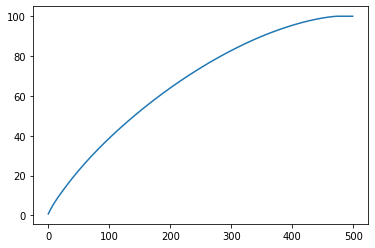

In [ ]:
ss = np.sqrt(s) * 100 / np.sum(np.sqrt(s))
import matplotlib.pyplot as plt
print(plt.plot(ss.cumsum()))